In [1]:
from erddapy import ERDDAP # /anaconda3/envs/colocators-ohw19/lib/python3.7/site-packages/erddapy
from erddapy import utilities

In [2]:
import json
import urllib
import requests
file = urllib.request.urlopen('https://raw.githubusercontent.com/IrishMarineInstitute/search-erddaps/master/erddaps.json')
all_servers = json.loads(file.read())
#file.getcode()

In [3]:
servers=all_servers

In [4]:
del servers[16] # skipping scoos server
#del servers[4]
len(servers)

27

In [5]:
time_min = '2016-07-10T00:00:00Z'
time_max = '2016-08-10T00:00:00Z'
bbox = [-72.0, -69, 38, 41]

kw = {
   'search_for': 'all',
   'min_lon': bbox[0],
   'max_lon': bbox[1],
   'min_lat': bbox[2],
   'max_lat': bbox[3],
   'min_time': time_min,
   'max_time': time_max,
   'standard_name': 'depth'
}

In [6]:
import pandas as pd
all_datasets=pd.DataFrame()

for key in servers:
    url = key['url']
    url = url.rstrip("/")
    e = ERDDAP(
                 server=url,
                 protocol='tabledap',
                 response='csv'
           )
    r = requests.get(e.get_search_url(**kw))
    try:
        r.raise_for_status()
        print(e.get_search_url(**kw))
        ds = pd.read_csv('%s'%e.get_search_url(**kw))
        ds['server'] = url
    
        datasets = ds[['server','Dataset ID','tabledap','Institution','Summary']]
    
        datasets.dropna(subset=['tabledap'],inplace=True)
    
        all_datasets = pd.concat([all_datasets,datasets])
    except requests.exceptions.HTTPError as err:
        print("Bad ERDDAP!!! {}".format(url))
    except requests.exceptions.RequestException as err:
        print("Bad ERDDAP!!! {}".format(url))
    except requests.exceptions.ConnectionError as err:
        print("Bad ERDDAP!!! {}".format(url))
    except requests.exceptions.Timeout as err:
        print("Bad ERDDAP!!! {}".format(url))
    except requests.exceptions.ConnectTimeout as err:
        print("Bad ERDDAP!!! {}").format(url)
        


https://coastwatch.pfeg.noaa.gov/erddap/search/advanced.csv?page=1&itemsPerPage=1000&protocol=(ANY)&cdm_data_type=(ANY)&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=depth&variableName=(ANY)&minLon=-72.0&maxLon=-69&minLat=38&maxLat=41&minTime=1468108800.0&maxTime=1470787200.0&searchFor=all


/anaconda3/envs/colocators-ohw19/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Bad ERDDAP!!! https://apdrc.soest.hawaii.edu/erddap
https://erddap.bco-dmo.org/erddap/search/advanced.csv?page=1&itemsPerPage=1000&protocol=(ANY)&cdm_data_type=(ANY)&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=depth&variableName=(ANY)&minLon=-72.0&maxLon=-69&minLat=38&maxLat=41&minTime=1468108800.0&maxTime=1470787200.0&searchFor=all
http://erddap.emodnet-physics.eu/erddap/search/advanced.csv?page=1&itemsPerPage=1000&protocol=(ANY)&cdm_data_type=(ANY)&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=depth&variableName=(ANY)&minLon=-72.0&maxLon=-69&minLat=38&maxLat=41&minTime=1468108800.0&maxTime=1470787200.0&searchFor=all
Bad ERDDAP!!! https://erddap.marine.ie/erddap
Bad ERDDAP!!! https://cwcgom.aoml.noaa.gov/erddap
http://erddap.sensors.ioos.us/erddap/search/advanced.csv?page=1&itemsPerPage=1000&protocol=(ANY)&cdm_data_type=(ANY)&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=de

In [7]:
all_datasets.head

<bound method NDFrame.head of                                      server             Dataset ID  \
0   https://coastwatch.pfeg.noaa.gov/erddap         scrippsGliders   
1   https://coastwatch.pfeg.noaa.gov/erddap           erdGtsppBest   
0         https://erddap.bco-dmo.org/erddap  bcodmo_dataset_549122   
0   http://erddap.emodnet-physics.eu/erddap      EP_INSITU_DRYT_TS   
1   http://erddap.emodnet-physics.eu/erddap      EP_INSITU_DRYT_TR   
..                                      ...                    ...   
5      http://tds.marine.rutgers.edu/erddap              DOPPIOobs   
6      http://tds.marine.rutgers.edu/erddap               ROMSSobs   
0         https://spraydata.ucsd.edu/erddap               binnedGS   
0       https://upwell.pfeg.noaa.gov/erddap         scrippsGliders   
1       https://upwell.pfeg.noaa.gov/erddap           erdGtsppBest   

                                             tabledap  \
0   https://coastwatch.pfeg.noaa.gov/erddap/tabled...   
1   https://coa

In [8]:
print('%i datasets found.' %all_datasets.shape[0])

122 datasets found.


In [9]:
df_coords = pd.DataFrame()
for i in range(all_datasets.shape[0]):
    server_url = all_datasets['server'].iloc[int(i)]
    dataset_id = all_datasets['Dataset ID'].iloc[int(i)]
    
    if "ROMS" in dataset_id or "DOP" in dataset_id: # skip ROMS model output
        print("Skipping %s" % server_url + dataset_id)
        continue
    print(i)
    e2 = ERDDAP(
                 server=server_url,
                 protocol='tabledap',
                 response='csv'
           )
    e2.variables=["latitude","longitude"]#,"time"]
    e2.dataset_id = all_datasets['Dataset ID'].iloc[int(i)]
    #e2.constraints = kw
    e2.constraints = {
           "time>=": time_min,
           "time<=": time_max,
           "longitude>=": bbox[0],
           "longitude<=": bbox[1],
           "latitude>=": bbox[2],
           "latitude<=": bbox[3],
           "distinct" : ()
    }
    r = requests.get(e2.get_download_url())
    try:
        r.raise_for_status()
        print(e2.get_download_url())
        df = e2.to_pandas()
        print("Found %i unique coordinates." % df.shape[0])
        df['dataset_count'] = i
        df['dataset_download_url'] = e2.get_download_url()
        df['Dataset ID'] = dataset_id

        df_coords = pd.concat([df_coords,df])
    except requests.exceptions.HTTPError as err:
        print("HTTPError data not within bounds!!! {}".format(e2.get_download_url()))
    except requests.exceptions.RequestException as err:
        print("RequestException data not within bounds!!! {}".format(e2.get_download_url()))
    except requests.exceptions.ConnectionError as err:
        print("ConnectionError data not within bounds!!! {}".format(e2.get_download_url()))
    except requests.exceptions.Timeout as err:
        print("Timeout data not within bounds!!! {}".format(e2.get_download_url()))
    except requests.exceptions.ConnectTimeout as err:
        print("ConnectionTimeout data not within bounds!!! {}".format(e2.get_download_url()))
    

    #print(e.get_download_url(response="csv"))
    
    #dataset_url = '%s/tabledap/%s.csvp?latitude,longitude,time&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&time>=1278720000.0&time<=1470787200.0&distinct()' % (all_datasets['server'].iloc[int(i)],all_datasets['Dataset ID'].iloc[int(i)])

df_coords.head()
print("\n\nCollected %i unique coordinate pairs from %i datasets" % 
      (df_coords.shape[0], len(df_coords['dataset_count'].unique())))

0
HTTPError data not within bounds!!! https://coastwatch.pfeg.noaa.gov/erddap/tabledap/scrippsGliders.csv?latitude,longitude&time>=1468108800.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&distinct()
1
https://coastwatch.pfeg.noaa.gov/erddap/tabledap/erdGtsppBest.csv?latitude,longitude&time>=1468108800.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&distinct()
Found 6 unique coordinates.
2
HTTPError data not within bounds!!! https://erddap.bco-dmo.org/erddap/tabledap/bcodmo_dataset_549122.csv?latitude,longitude&time>=1468108800.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&distinct()
3
http://erddap.emodnet-physics.eu/erddap/tabledap/EP_INSITU_DRYT_TS.csv?latitude,longitude&time>=1468108800.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&distinct()
Found 1 unique coordinates.
4
HTTPError data not within bounds!!! http://erddap.emodnet-physics.eu/erddap/tabledap

http://erddap.emodnet-physics.eu/erddap/tabledap/EP_INSITU_WSPD_TS.csv?latitude,longitude&time>=1468108800.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&distinct()
Found 1 unique coordinates.
36
HTTPError data not within bounds!!! http://erddap.emodnet-physics.eu/erddap/tabledap/EP_INSITU_WSPD_TR.csv?latitude,longitude&time>=1468108800.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&distinct()
37
HTTPError data not within bounds!!! http://erddap.emodnet-physics.eu/erddap/tabledap/EP_INSITU_PRRT_TS.csv?latitude,longitude&time>=1468108800.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&distinct()
38
HTTPError data not within bounds!!! http://erddap.emodnet-physics.eu/erddap/tabledap/EP_INSITU_LGHT_PR.csv?latitude,longitude&time>=1468108800.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&distinct()
39
HTTPError data not within bounds!!! http://erddap.emodnet-physic

HTTPError data not within bounds!!! http://erddap.emodnet-physics.eu/erddap/tabledap/EP_INSITU_EWCT_TR.csv?latitude,longitude&time>=1468108800.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&distinct()
71
http://erddap.emodnet-physics.eu/erddap/tabledap/EP_INSITU_WDIR_TS.csv?latitude,longitude&time>=1468108800.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&distinct()
Found 1 unique coordinates.
72
HTTPError data not within bounds!!! http://erddap.emodnet-physics.eu/erddap/tabledap/EP_INSITU_WDIR_TR.csv?latitude,longitude&time>=1468108800.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&distinct()
73
http://erddap.sensors.ioos.us/erddap/tabledap/cp_340_20160809t0230.csv?latitude,longitude&time>=1468108800.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&distinct()
Found 5 unique coordinates.
74
http://erddap.sensors.ioos.us/erddap/tabledap/cp_374_20160529t0035.csv?l

Found 41 unique coordinates.
106
http://www.myroms.org:8080/erddap/tabledap/PIONEER_MOAS_TEMP_SALT_GL374.csv?latitude,longitude&time>=1468108800.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&distinct()
Found 893877 unique coordinates.
107
http://www.myroms.org:8080/erddap/tabledap/PIONEER_MOAS_TEMP_SALT_GL376.csv?latitude,longitude&time>=1468108800.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&distinct()
Found 976317 unique coordinates.
108
HTTPError data not within bounds!!! http://www.myroms.org:8080/erddap/tabledap/PIONEER_MOAS_TEMP_SALT_GL379.csv?latitude,longitude&time>=1468108800.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&distinct()
109
http://www.myroms.org:8080/erddap/tabledap/PIONEER_MOAS_TEMP_SALT_GL387.csv?latitude,longitude&time>=1468108800.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&distinct()
Found 27892 unique coordinates.
110
http://ww

Text(0.5, 1.0, '47 datasets')

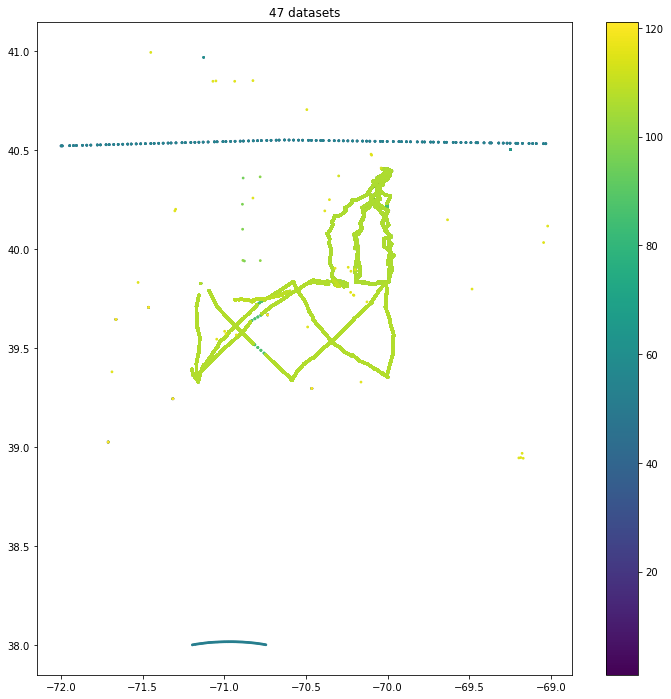

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12)) #make_map(extent, figsize=(6, 6))\n",
#add_etopo2(extent, ax)\n",
plt.scatter(df_coords['longitude (degrees_east)'],
               df_coords['latitude (degrees_north)'],
               s=3, c=df_coords['dataset_count'].values)
plt.colorbar()
plt.title("%i datasets" % len(df_coords['dataset_count'].unique()))
#df.plot(x='longitude (degrees_east)',y='latitude (degrees_north)')"

In [11]:
df_coords
# need to skip ROMS data: http://tds.marine.rutgers.edu/erddap/tabledap/ROMSSobs.htmlTable?latitude,longitude,time&time%3E=1468108800.0&time%3C=1470787200.0&longitude%3E=-72.0&longitude%3C=-69&latitude%3E=38&latitude%3C=41&distinct()

,latitude (degrees_north),longitude (degrees_east),dataset_count,dataset_download_url,Dataset ID
0,39.025,-71.711,1,https://coastwatch.pfeg.noaa.gov/erddap/tabled...,erdGtsppBest
1,39.244,-71.315,1,https://coastwatch.pfeg.noaa.gov/erddap/tabled...,erdGtsppBest
2,39.296,-70.464,1,https://coastwatch.pfeg.noaa.gov/erddap/tabled...,erdGtsppBest
3,39.645,-71.664,1,https://coastwatch.pfeg.noaa.gov/erddap/tabled...,erdGtsppBest
4,39.668,-70.735,1,https://coastwatch.pfeg.noaa.gov/erddap/tabled...,erdGtsppBest
...,...,...,...,...,...
1,39.244,-71.315,121,https://upwell.pfeg.noaa.gov/erddap/tabledap/e...,erdGtsppBest
2,39.296,-70.464,121,https://upwell.pfeg.noaa.gov/erddap/tabledap/e...,erdGtsppBest
3,39.645,-71.664,121,https://upwell.pfeg.noaa.gov/erddap/tabledap/e...,erdGtsppBest
4,39.668,-70.735,121,https://upwell.pfeg.noaa.gov/erddap/tabledap/e...,erdGtsppBest


In [12]:
e2.variables

['latitude', 'longitude']

In [13]:
# from erddapy import ERDDAP


# e = ERDDAP(
#   server='https://data.ioos.us/gliders/erddap',
#   protocol='tabledap',
# )

# e.response = 'csv'
# e.dataset_id = 'whoi_406-20160902T1700'
# e.constraints = {
#     'time>=': '2016-07-10T00:00:00Z',
#     'time<=': '2017-02-10T00:00:00Z',
#     'latitude>=': 38.0,
#     'latitude<=': 41.0,
#     'longitude>=': -72.0,
#     'longitude<=': -69.0,
# }
# e.variables = [
#     'depth',
#     'latitude',
#     'longitude',
#     'salinity',
#     'temperature',
#     'time',
# ]

In [14]:
#     if url != 'http://erddap.emodnet-physics.eu/erddap' and \
#     url != 'https://erddap.marine.ie/erddap' and \
#     url != 'http://oos.soest.hawaii.edu/erddap' and \
#     url != 'http://erddap.secoora.org/erddap' and \
#     url != 'https://ecowatch.ncddc.noaa.gov/erddap' and \
#     url != 'http://dap.onc.uvic.ca/erddap':

In [15]:
# laturl = 'http://erddap.bco-dmo.org/erddap/categorize/variableName/latitude/index.csv'
# lonurl = 'http://erddap.bco-dmo.org/erddap/categorize/variableName/longitude/index.csv'

# df_lat = pd.read_csv(laturl, header=[0])
# df_lon = pd.read_csv(lonurl, header=[0])

# df_datasets = pd.merge(df_lat, df_lon, on='Dataset ID')
# df_final = pd.DataFrame(columns=['latitude (degrees_north)', 'longitude (degrees_east)', 'Dataset ID'])

# for did in df_datasets['Dataset ID']:
#     if did != 'bcodmo_dataset_739309': # remove this once we reload all the datasets again.
#         dataset_url = 'http://erddap.bco-dmo.org/erddap/tabledap/%s.csvp?latitude,longitude&distinct()' % did
#         df_data = pd.read_csv(dataset_url, header=0, usecols=['latitude (degrees_north)', 'longitude (degrees_east)'])
#         df_data['Dataset ID'] = did
#         df_final = pd.concat([df_final, df_data], sort=False, ignore_index=True)
#         print(df_final.shape)

# lon = df_final['longitude (degrees_east)'].values
# lat = df_final['latitude (degrees_north)'].values